# ID2223 – Lab 2:  Deep Learning with TensorFlow

For this lab we will use a dataset called Fashion-MNIST. The original MNIST dataset (Mixed National Institute of Standards and Technology database) is a database of handwritten digits that is commonly used for evaluating image classification algorithms. You can read more about the dataset in Yann LeCun’s MNIST page or Chris Olah’s visualizations of MNIST. MNIST is considered the HelloWorld dataset for Deep Learning, however, for this lab, MNIST is too easy to get very high accuracy on.

As such, we will use Fashion-MNIST - a drop-in replacement for the original MNIST, released by Zalando. It contains images of various articles of clothing and accessories: shirts, bags, shoes, and other fashion items. The Fashion MNIST training set contains 55,000 examples, and the test set contains 10,000 examples. Each example is a 28x28 grayscale image (just like the images in the original MNIST), associated with a label from 10 classes (t-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots).

This lab has the following goals:

- Learn how to setup and run a computational graph in Tensorflow
- Implement a single-layer as well as a multi-layer Neural Network in Tensorflow
- Combine different activation functions to increase the accuracy
- Tackle overfitting using regularization
- Further improve the performance by using Convolutional Layers
- Use hyperparameter optimization to improve prediction accuracy

In [1]:
# create data/fashion folder, if it doesn't exist
import os
if not os.path.exists("data/fashion"): os.makedirs("data/fashion")

In [2]:
# Download the labels from the Fashion MNIST data
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz --directory-prefix=./data/fashion/
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz --directory-prefix=./data/fashion/
# Download the images from the Fashion MNIST data
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz --directory-prefix=./data/fashion/
#!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz --directory-prefix=./data/fashion/

In [3]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data
# numpy library
import numpy as np
# random library
from random import randint
# datetime library
from datetime import datetime
%matplotlib inline
tf.set_random_seed(0)

In [4]:
# load data
mnist = input_data.read_data_sets('data/fashion', one_hot=True)

Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


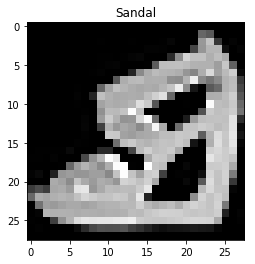

In [5]:
def gen_image(arr, im_title):
    image_data = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.title(im_title)
    plt.imshow(image_data, interpolation='nearest', cmap='gray')
    return plt

fash_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Produces a random image
im_index = randint(0, 100)
batch__X, batch__Y = mnist.test.next_batch(100)
gen_image(batch__X[im_index], fash_labels[np.nonzero(batch__Y[im_index] == 1)[0][0]]).show()

# Convolutional Neural Network

In this section you will change your neural network to use convolutional layers. In the previous tasks, we have reshaped our input from a matrix to a vector from the very beginning, however, this means that we lose precious information that could be
including in the learning task. By getting rid of the matrix in the beginning we lose locality information. We lose the fact that the digits have lines and curves in them. The convolutional layers that we will add to the network will let us extract and compose higher level features from this locality information.

It is important to understand the shape of the input/output of your convolutional layers and what changes the shape of the input to that of the output. The weight variables from your convolutional layers should follow 4-dimensional tensors of (patch_height,
patch_width, input_channels, output_channels).

This tensor defines the weights structure of one unit in the layer. The patch is the area of the image that the unit will try
to look at. The input to the whole layer is a 4 dimensional tensor of (batch_size, image_height, image_width, input_channels). 

The stride defines how to move the patch over the layer’s input data in order to compute a unit’s input data. Thus, the stride’s
structure is also 4 dimensional: (batch_step, height_step, width_step, channel_step).

Keep in mind that if the stride has any element bigger than 1 in its structure it will reduce that particular dimension in the output of the layer. Next we provide a full layer parameter description.

Conv layer 1
The input data is (batch_size, image_height, image_width, input_channels) = (100,28,28,1)
- stride of (1,1,1,1)
- patch of 5X5
- input depth/channels of 1
- output depth/channels of 4

Conv layer 2
- stride of (1,2,2,1)
- patch of 5X5
- input depth/channels of 4 - previous output
- output depth/channels of 8

Conv layer 3
- stride of (1,2,2,1)
- patch of 4X4
- input depth/channels of 8 - previous output
- output depth/channels of 12

Densely connected layer

The output from the third layer is a four dimensional tensor of (batch, height, width, depth). The densely connected layer is a relu layer like the ones defined in previous tasks and takes as input two dimension tensor of (batch, values). You will need to reshape the tensor from having height X width X depth in matrix form to having a vector of height* width * depth elements.
- input structure - determine it from the previous layer output
- output structure: vector of 200 elements

Readout layer
The readout layer is the same softmax layer from the previous tasks.
- input structure: a vector of 200 elements
- output structure: vector of 10 elements

Task 4
Your programming part of this task includes:
1. Setup the network layer with 3 conv layers, 1 relu layer and 1 softmax layer with a GradientDescentOptimizer.
2. Change the optimizer to the AdamOptimizer.
3. Add a learning decay to the network.
4. Add regularization through dropout.

Your analysis part of this task includes:
- Define the output structure of the convolutional layers based on the given stride.
- For each of the programming subtasks 2-4 point out the changes that happen to the accuracy and error and explain why your modifications caused those changes.

In [6]:
# 1. Define Variables and Placeholders
num_pixels = 28
num_inputs = num_pixels*num_pixels
num_outputs = 10
gd_learning_rate = 0.5
ad_learning_rate = 0.005

# to compute the decayed learning rate
# remember that decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
global_step = tf.Variable(0, trainable=False)
decay_steps = 100
decay_rate = 0.96

num_hidd_1 = 200
num_hidd_2 = 100
num_hidd_3 = 60
num_hidd_4 = 30

X = tf.placeholder(tf.float32, [None, num_pixels, num_pixels, 1], name="X") #(None) will index the images in the mini-batch
Y_ = tf.placeholder(tf.float32,[None, num_outputs], name="Y_") # correct answers(labels)
XX = tf.reshape(X, [-1, num_inputs]) # flatten the images into a single line of pixels
keep_prob = tf.placeholder(tf.float32) #prob.of keeping a node during dropout: 1.0 at testing (no dropout) and 0.75 at training

# Weights & bias initialization
# One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients.
# Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias 
# to avoid "dead neurons"
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Convolution
def conv2d(X, W, strides):
  return tf.nn.conv2d(X, W, strides=strides, padding='SAME')

In [7]:
# 2. Define the model:

# To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to 
# image width and height, and the final dimension corresponding to the number of color channels.
x_image = tf.reshape(XX, [-1, num_pixels, num_pixels, 1])

# Conv.Layer 1: patch of 5x5, 1 input channel, 4 output channels, stride of [1,1,1,1]
W_conv1 = weight_variable([5, 5, 1, 4])
B_conv1 = bias_variable([4])
H_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, [1, 1, 1, 1]) + B_conv1)

# Conv.Layer 2: patch of 5x5, 4 input channel, 8 output channels, stride of [1,2,2,1]
W_conv2 = weight_variable([5, 5, 4, 8])
B_conv2 = weight_variable([8])
H_conv2 = tf.nn.relu(conv2d(H_conv1, W_conv2, [1, 2, 2, 1]) + B_conv2)
# NOTE:the image size has been reduced to 14x14 (because of the used stride)

# Conv.Layer 3: patch of 4x4, 8 input channel, 12 output channels, stride of [1,2,2,1]
W_conv3 = weight_variable([4, 4, 8, 12])
B_conv3 = weight_variable([12])
H_conv3 = tf.nn.relu(conv2d(H_conv2, W_conv3, [1, 2, 2, 1]) + B_conv3)
# NOTE:the image size has been reduced to 7x7 (because of the used stride)

# Fully connected layer (ReLU): input = vector of 12*7*7 elements, output = vector of 200 elements
# NOTE: You will need to reshape the tensor from having height X width X depth in matrix form 
# to having a vector of height * width * depth elements.
W_fc1 = weight_variable([7 * 7 * 12, 200])
B_fc1 = weight_variable([200])
H_fc1 = tf.nn.relu(tf.matmul(tf.reshape(H_conv3,[-1, 7 * 7 * 12]),W_fc1) + B_fc1)
D_fc1 = tf.nn.dropout(H_fc1, keep_prob)

# Readout layer (Softmax): input = vector of 200 elements, output = vector of 10 elements
W_fc2 = weight_variable([200, num_outputs])
B_fc2 = bias_variable([num_outputs])

#YLogits: values to be used as input to softmax
YL = tf.matmul(D_fc1, W_fc2) + B_fc2

In [8]:
# 3. Define the loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=YL, name="loss"))

# 4. Define the accuracy
correct = tf.equal(tf.argmax(YL,1), tf.argmax(Y_,1)) #tf.nn.in_top_k(Y,Y_,1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
# 5.1 Train with the GradientDescentOptimizer and a starter learning rate of 0.5
#learning_rate = tf.train.exponential_decay(gd_learning_rate, global_step, decay_steps, decay_rate, staircase=True)
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
train_step = tf.train.GradientDescentOptimizer(gd_learning_rate).minimize(cross_entropy)

In [9]:
# 5.2 Train with the AdamOptimizer (a slightly better optimizer) and a starter learning rate of 0.005
learning_rate = tf.train.exponential_decay(ad_learning_rate, global_step, decay_steps, decay_rate, staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
#train_step = tf.train.AdamOptimizer(ad_learning_rate).minimize(cross_entropy)

In [10]:
# initialize
init = tf.global_variables_initializer()#tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [11]:
def training_step(i, update_test_data, update_train_data):
    
    #print("Iteration n."+str(i))
        
    # actual learning
    batch_X, batch_Y = mnist.train.next_batch(100) # reading batches of 100 images with 100 labels
    sess.run(train_step, feed_dict={XX: batch_X, Y_: batch_Y, keep_prob: 0.75}) # the backpropagation training step
    
    # evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: batch_X, Y_: batch_Y, keep_prob: 0.75})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: mnist.test.images, Y_: mnist.test.labels, keep_prob: 1.0})
        test_a.append(a)
        test_c.append(c)
        
    return (train_a, train_c, test_a, test_c)

In [12]:
training_iter = 10000
#training_iter = 20000

In [13]:
# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []

epoch_size = 100

begda = datetime.now()

for i in range(training_iter):
    #When you compute accuracy and loss you run the whole training/testing dataset
    #through your current model and this is quite expensive. Doing so every iteration would
    #make it impractical, so you will compute it every 100 rounds, which we can call epochs.    
    test = False
    if i % epoch_size == 0: 
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

Time: 0:08:34.123683
Max.train accuracy:1.0
Max.test accuracy:0.9118


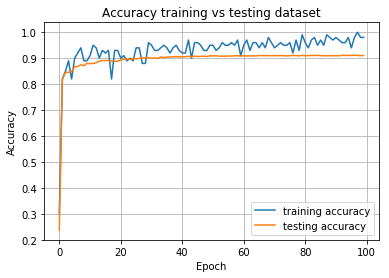

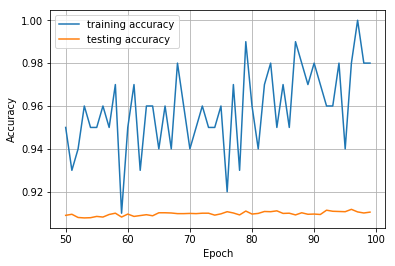

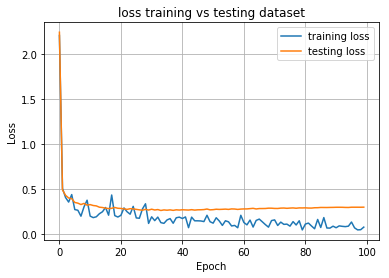

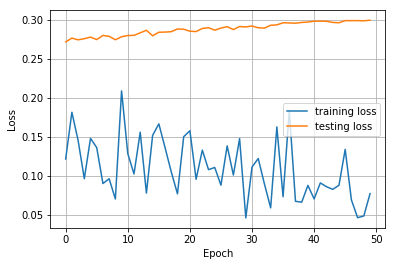

In [14]:
# 7. Plot and visualise the accuracy and loss

print("Time: "+str(datetime.now()-begda))
print("Max.train accuracy:"+str(max(train_a)))
print("Max.test accuracy:"+str(max(test_a)))

# Accuracy training vs testing dataset
plt.title('Accuracy training vs testing dataset')
plt.plot(train_a, label='training accuracy')
plt.plot(test_a, label='testing accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,int(training_iter/epoch_size))
plt.plot(x_range, train_a[zoom_point:], label='training accuracy')
plt.plot(x_range, test_a[zoom_point:], label='testing accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

# loss training vs testing dataset
plt.title('loss training vs testing dataset')
plt.plot(train_c, label='training loss')
plt.plot(test_c, label='testing loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(train_c[zoom_point:],label='training loss')
plt.plot(test_c[zoom_point:],label='testing loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()